<a href="https://colab.research.google.com/github/insomaniac2k2/Food-vision/blob/main/07_food_vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-29 12:19:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-29 12:19:59 (83.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Tensorflow datasets to lad data

In [4]:
import tensorflow_datasets as tfds

In [5]:
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [33]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split = ['train','validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [34]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [35]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [36]:
train_one_sample = train_data.take(1)

In [37]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [38]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 289, 3)
  Image datatype: <dtype: 'uint8'>
  Target: 45
  Class name: frozen_yogurt
  


In [39]:
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [40]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image

(-0.5, 288.5, 511.5, -0.5)

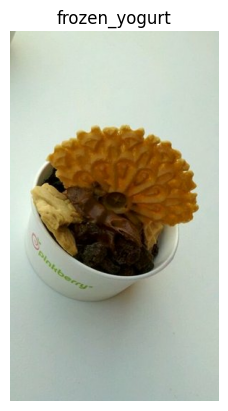

In [41]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis('off')

## Creating preprocessing functions

In [42]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [43]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image after preprocessing: {preprocessed_img[:2]}\n shape: {preprocessed_img.shape}")

Image after preprocessing: [[[147.19739 153.19739 127.19739]
  [157.22768 163.22768 137.22768]
  [158.09805 164.09805 138.09805]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [198.09914 208.38936 199.24425]]

 [[154.69467 160.69467 134.69467]
  [155.87053 161.87053 135.87053]
  [158.39908 164.39908 138.39908]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [196.32831 206.61853 195.76364]]]
 shape: (224, 224, 3)


## Batch and prepare datasets

In [44]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [45]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [46]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [47]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [48]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Feature extraction model

In [49]:
from tensorflow.keras import layers

input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

## Checking layer dtype policies

In [51]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [52]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
rescaling_5 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

## Fit the feature extraction model

In [53]:
history_101 = model.fit(train_data,
                        epochs=3,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[create_tensorboard_callback('training_logs',
                                                               'efficientnetb0'),
                                   model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0/20230529-124339
Epoch 1/3
2368/2368 [==============================] - 199s 80ms/step - loss: 1.7176 - accuracy: 0.5825 - val_loss: 1.1261 - val_accuracy: 0.7034
Epoch 2/3
2368/2368 [==============================] - 198s 82ms/step - loss: 1.1986 - accuracy: 0.6884 - val_loss: 1.0302 - val_accuracy: 0.7201
Epoch 3/3
2368/2368 [==============================] - 192s 79ms/step - loss: 1.0525 - accuracy: 0.7250 - val_loss: 0.9887 - val_accuracy: 0.7291


In [54]:
model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 0.9972 - accuracy: 0.7307


[0.9972209334373474, 0.7306930422782898]